In [29]:
import sionna as sn
import numpy as np
import matplotlib.pyplot as plt

In [30]:
BATCH_SIZE = 10
NUM_BITS_PER_SYMBOL = 4
CODERATE = 0.5
NUM_CODED_BITS = 1000
NUM_INFO_BITS = int(NUM_CODED_BITS * CODERATE)
snrs = np.linspace(-5,5,11)

NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 4
NUM_STREAMS_PER_TX = NUM_UT_ANT

RX_TX_ASSOCIATION = np.array([[1]])
STREAM_MANAGEMENT = sn.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

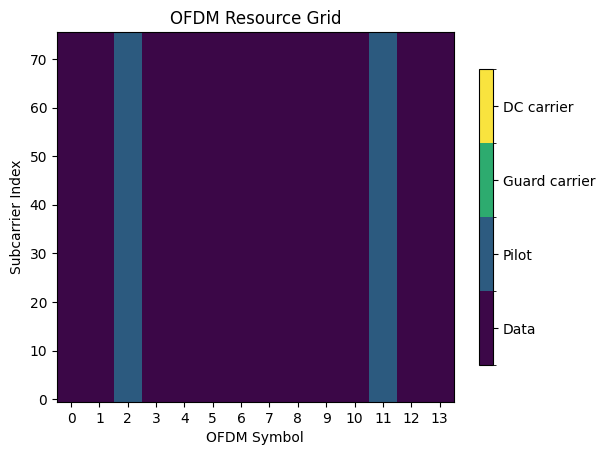

In [31]:
resource_grid = sn.ofdm.ResourceGrid(
    num_ofdm_symbols=14,
    fft_size=76,
    subcarrier_spacing=30e3,
    num_tx=NUM_UT,
    num_streams_per_tx=NUM_STREAMS_PER_TX,
    cyclic_prefix_length=6,
    pilot_pattern="kronecker",
    pilot_ofdm_symbol_indices=[2,11]
)

resource_grid.show();

In [32]:
CARRIER_FREQUENCY = 1.9e9

ut_array = sn.channel.tr38901.Antenna(
    polarization='single',
    polarization_type='V',
    antenna_pattern='omni',
    carrier_frequency=CARRIER_FREQUENCY
)

bs_array = sn.channel.tr38901.AntennaArray(
    num_rows=1,
    num_cols=int(NUM_BS_ANT/2),
    polarization='dual',
    polarization_type='cross',
    antenna_pattern='38.901',
    carrier_frequency=CARRIER_FREQUENCY
)

In [33]:
DELAY_SPREAD = 100e-9
DIRECTION = 'uplink'
CDL_MODEL = 'C'
SPEED = 0.0

CDL = sn.channel.tr38901.CDL(
    CDL_MODEL,
    DELAY_SPREAD,
    CARRIER_FREQUENCY,
    ut_array=ut_array,
    bs_array=bs_array,
    direction=DIRECTION,
    min_speed=SPEED
)

In [34]:
a, tau = CDL(
    batch_size=BATCH_SIZE,
    num_time_steps=resource_grid.num_ofdm_symbols,
    sampling_frequency=1/resource_grid.ofdm_symbol_duration
)

In [35]:
NUM_CODED_BITS = int(resource_grid.num_data_symbols * NUM_BITS_PER_SYMBOL)
NUM_INFO_BITS = int(NUM_CODED_BITS * CODERATE)

constellation = sn.utils.Constellation('qam', NUM_BITS_PER_SYMBOL)

binary_source = sn.utils.BinarySource()

ldpc_encoder = sn.fec.ldpc.LDPC5GEncoder(NUM_INFO_BITS, NUM_CODED_BITS)
ldpc_decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=ldpc_encoder, hard_out=True)

mapper = sn.mapping.Mapper('qam', NUM_BITS_PER_SYMBOL)
demapper = sn.mapping.Demapper('app', constellation=constellation)

rg_mapper = sn.ofdm.ResourceGridMapper(resource_grid)

ls_est = sn.ofdm.LSChannelEstimator(resource_grid, interpolation_type='nn')

lmmse_equ = sn.ofdm.LMMSEEqualizer(resource_grid, STREAM_MANAGEMENT)

channel = sn.channel.OFDMChannel(
    CDL,
    resource_grid,
    add_awgn=True,
    normalize_channel=True,
    return_channel=True
)

In [40]:


bits = binary_source([BATCH_SIZE, NUM_UT, resource_grid.num_streams_per_tx, NUM_INFO_BITS])
codewords = ldpc_encoder(bits)
qam_symbols = mapper(codewords)
ofdm_symbols = rg_mapper(qam_symbols)

bers = []

for SNR in snrs:

  no = sn.utils.ebnodb2no(
    SNR,
    NUM_BITS_PER_SYMBOL,
    CODERATE,
    resource_grid
  )

  response, freqs = channel([ofdm_symbols, no])

  estimation, err_var = ls_est([response, no])
  equalized_symbols, no_eff = lmmse_equ([response, estimation, err_var, no])

  llr = demapper([equalized_symbols, no_eff])
  bits_hat = ldpc_decoder(llr)

  ber = np.sum(abs(bits - bits_hat))/np.size(bits)

  print(f'SNR = {SNR} | BER = {ber}')

  bers.append(ber)

SNR = -5.0 | BER = 0.3905701754385965
SNR = -4.0 | BER = 0.3698464912280702
SNR = -3.0 | BER = 0.34155701754385964
SNR = -2.0 | BER = 0.3161732456140351
SNR = -1.0 | BER = 0.2862390350877193
SNR = 0.0 | BER = 0.25526315789473686
SNR = 1.0 | BER = 0.2238486842105263
SNR = 2.0 | BER = 0.1788377192982456
SNR = 3.0 | BER = 0.011951754385964913
SNR = 4.0 | BER = 0.0
SNR = 5.0 | BER = 0.0


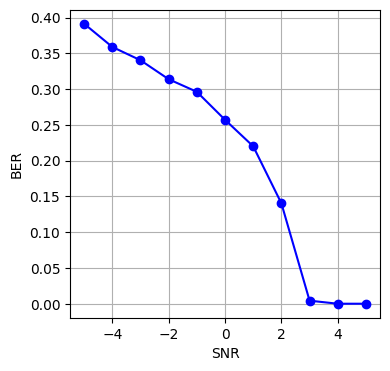

In [38]:
plt.figure(figsize=(4,4))
plt.plot(snrs, bers, color='b', marker='o')
plt.xlabel('SNR')
plt.ylabel('BER')
plt.grid()

In [23]:
print(f'BER: {np.sum(abs(bits - bits_hat))/np.size(bits)}')

BER: 0.0
